<a href="https://colab.research.google.com/github/jplumail/water-meters/blob/master/Plumail_Homework_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toloka Water Meters Dataset using ResNet

This notebook shows how to train a CNN for waters meters detection (bounding box only) using a Toloka's dataset.

# Downloading the data

In [ ]:
!wget https://tlk.s3.yandex.net/dataset/TlkWaterMeters.zip
!unzip -o TlkWaterMeters.zip

# Defining train and test datasets

Toloka's water meters are represented as polygons (list of image points), the associated **bounding box** is the rectangle that fully overlap this polygon. We represent this rectangle by its top left corner and bottom right corner points, ie 4 coordinates (x1, y1, x2, y2). These coordinates are normalized by the height and the width of the image so that they are in the range [0,1].

We do **data augmentation** : rotating and flipping left-right, top-bottom randomly.
The images are **resized** and **normalized**.

In [4]:
import os
from PIL import Image, ImageOps
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

def converter(data):
    dicts = json.loads(data.replace("\'", "\""))
    x_val = np.array([dic['x'] for dic in dicts['data']])
    y_val = np.array([dic['y'] for dic in dicts['data']])
    return [y_val.min(), x_val.min(), y_val.max(), x_val.max()]

class WaterMetersDataset(data.Dataset):
    def __init__(self, root_dir, mode="train"):
        self.mode = mode
        self.df = pd.read_csv(os.path.join(root_dir,"data.tsv"), sep="\t", converters={'location':converter}, quotechar="'")
        self.im_dir = os.path.join(root_dir, "images")
        self.resize = transforms.Resize((256,256))
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet default normalization
        ])
    def __len__(self):
        return len(self.df)
    
    def applyRandomTransformation(self, im, bbox):
        bbox = bbox.reshape(-1).tolist()
        r = np.random.random(3)
        if r[0] > 0.5: # flipping upside down
            im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
            bbox = [1-bbox[2], bbox[1], 1-bbox[0], bbox[3]]
        if r[1] > 0.5: # flipping left right
            im = im.transpose(method=Image.FLIP_LEFT_RIGHT)
            bbox = [bbox[0], 1-bbox[3], bbox[2],1-bbox[1]]
        n_rot = int(r[2] // 0.25)
        for i in range(n_rot): # Do 0 to 3 90° rotations counter clockwise
            im = im.transpose(method=Image.ROTATE_90)
            bbox = [1-bbox[3], bbox[0], 1-bbox[1], bbox[2]]
        bbox = np.array(bbox).reshape(-1,4)
        return im, bbox

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = int(idx.tolist()[0])

        im_name = self.df.photo_name.iloc[idx]
        im = Image.open(os.path.join(self.im_dir, im_name))
        im = ImageOps.exif_transpose(im)
        bbox = np.array([self.df.location.iloc[idx]]).astype('float').reshape(-1,4)

        if self.mode == "test":
            return im, bbox
        
        im = self.resize(im)
        if self.mode == "train": # Data augmentation
            im, bbox = self.applyRandomTransformation(im, bbox)
        im = self.transform(im)
        
        return im, bbox

dataset_train = WaterMetersDataset("TlkWaterMeters", mode="train") # adds data augmentation
dataset_val = WaterMetersDataset("TlkWaterMeters", mode="val")
dataset_size = len(dataset_train)
indices = list(range(dataset_size))
validation_split = 0.8
split = int(np.floor(validation_split * dataset_size))
indices_train, indices_val = indices[:split], indices[split:]
train_sampler = data.sampler.SubsetRandomSampler(indices_train)
valid_sampler = data.sampler.SubsetRandomSampler(indices_val)

dataset = WaterMetersDataset("TlkWaterMeters")
dataloader_train = data.DataLoader(dataset_train, batch_size=32, sampler=train_sampler)
dataloader_val = data.DataLoader(dataset_val, batch_size=32, sampler=valid_sampler)

# Defining the CNN and the optimizer
Skip this cell if you don't want to train the model.

This is a regression problem with 4 scalars as output. We adapt the last layer of the **ResNet** model and choose the **MSELoss** for our problem.

In [ ]:
model = models.resnet18()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Changing the last layer 
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = nn.MSELoss()

train_losses = []
eval_losses = []
best_loss = np.inf

# Training
Skip the next cells if you don't train the model.

In [ ]:
model.to(device)
num_epochs = 100
for e in range(num_epochs):
    print("Epoch", e)
    model.train()
    running_loss_train = 0

    # Training
    for ims, bboxs in dataloader_train:
        ims = ims.to(device)
        bboxs = bboxs.squeeze(1).to(device)
        optimizer.zero_grad()
        pred_bboxs = model(ims)
        loss = criterion(pred_bboxs.float(), bboxs.float())
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * ims.size(0)
    epoch_train_loss = running_loss_train / len(indices_train)

    # Testing
    model.eval()
    running_loss_eval = 0
    for ims, bboxs in dataloader_val:
        ims = ims.to(device)
        bboxs = bboxs.squeeze(1).to(device)
        with torch.no_grad():
            pred_bboxs = model(ims)
            loss = criterion(pred_bboxs.float(), bboxs.float())
        running_loss_eval += loss.item() * ims.size(0)
    epoch_eval_loss = running_loss_eval / len(indices_val)

    # Saving
    if epoch_eval_loss < best_loss:
        print("Saving!")
        torch.save(model.state_dict(), "resnet3.pt")
        best_loss = epoch_eval_loss
    print('Train loss: {:.4f}'.format(epoch_train_loss))
    print('Eval loss: {:.4f}'.format(epoch_eval_loss))
    train_losses.append(epoch_train_loss)
    eval_losses.append(epoch_eval_loss)
    scheduler.step(epoch_eval_loss)

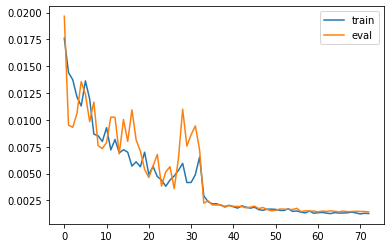

In [ ]:
plt.plot(train_losses[1:], label="train")
plt.plot(eval_losses[1:], label="eval")
plt.legend()

# Testing the model

You can download the trained ResNet and test it on the Toloka dataset. The inference time on CPU (Colab CPU) is around 0.1s for a 1000x1000x3 image. We achieve a pretty good accuracy.

In [ ]:
!wget https://github.com/jplumail/water-meters/raw/master/resnet3.pt

Inference time on CPU : 0.1s
Loss :  0.00016867437420242036


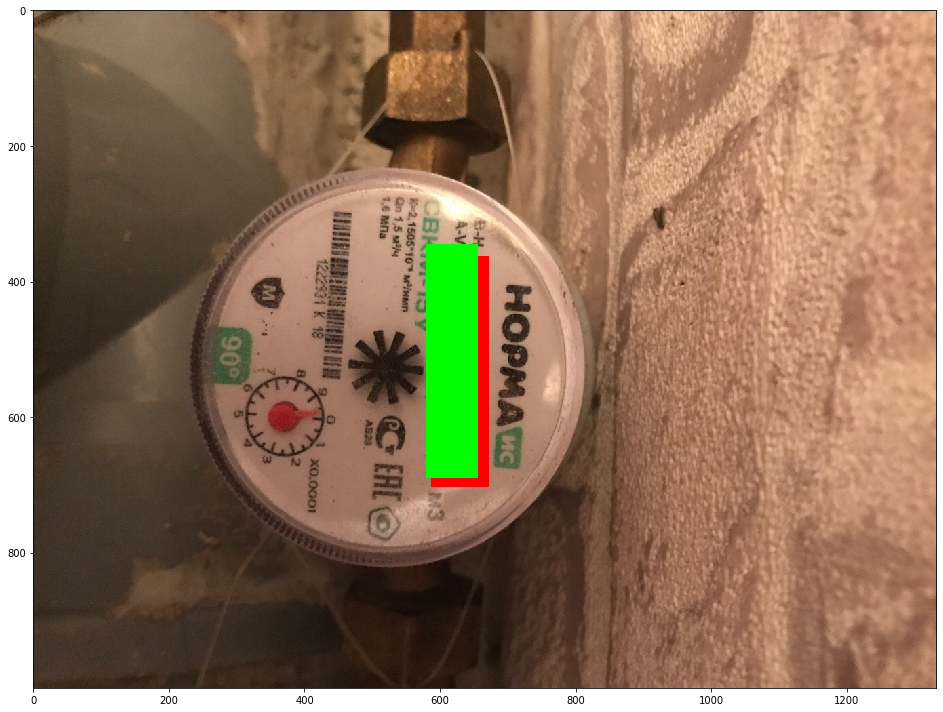

In [21]:
from time import time
from skimage import io, draw

i = 6
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model.to("cpu")
model.load_state_dict(torch.load("resnet3.pt"))
model.eval()

dataset_test = WaterMetersDataset("TlkWaterMeters", mode="test")

im, bbox = dataset_test[indices_val[i]]
im_arr = np.array(im)
im_resized = dataset_test.resize(im)
im_tensor = dataset_test.transform(im_resized)
bbox = bbox.reshape(-1)

t0 = time()
with torch.no_grad():
    bbox_pred = model(im_tensor.reshape(1,3,256,256))[0].numpy()
print("Inference time on CPU : %.1fs"%(time()-t0))
print("Loss : ", np.mean((bbox-bbox_pred)**2))

plt.figure(figsize=(20,10))
h, w, _ = im_arr.shape
rr, cc = draw.rectangle((int(bbox[0]*h),int(bbox[1]*w)), (int(bbox[2]*h), int(bbox[3]*w)))
im_arr[rr,cc] = [255,0,0]
rr, cc = draw.rectangle((int(bbox_pred[0]*h),int(bbox_pred[1]*w)), (int(bbox_pred[2]*h), int(bbox_pred[3]*w)))
im_arr[rr,cc] = [0,255,0]
io.imshow(im_arr)